## Downloading Data

In [16]:
from wordcloud import WordCloud
import string
from collections import defaultdict
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')

df=pd.read_csv("Restaurant reviews.csv")
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorasencio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


## Preprocessing

In [17]:
df = df.drop(["Restaurant", "Reviewer", "Metadata", "Pictures" ,"7514"], axis=1)
df["Time"] = list(map(lambda data: str(data).split()[0], df["Time"]))
df["Time"] = list(map(lambda data: str(data).split("/")[-1], df["Time"]))
df['Rating'] = np.where(df["Rating"] == "Like", df['Rating'].value_counts().idxmax(), df['Rating'])
df["Rating"] = list(map(lambda data: float(data) >= 3, df["Rating"]))

mmsTime = MinMaxScaler()

mmsTime.fit(df[["Time"]])
df["Time"] = mmsTime.transform(df[["Time"]])

df["Review"] = df["Review"].fillna("Nothing")
df['Rating'] = df['Rating'].astype(int)
df.rename(columns={'Rating': 'target'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Review  10000 non-null  object 
 1   target  10000 non-null  int64  
 2   Time    9962 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [18]:
def create_corpus_df(review, target):
    corpus=[]
    
    for x in review[review['target']==target]['Review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [19]:
restaurant_reviews = create_corpus_df(df, 1)

dic=defaultdict(int)
for word in restaurant_reviews:
    dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [20]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(
        'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 
        '', 
        text
    )
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [21]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

def preprocess_data(text):
    text = clean_text(text)
    #Double nettoyage
    text = ' '.join(stemmer.stem(word) for word in text.split(' ') if word not in stop_words)

    return text

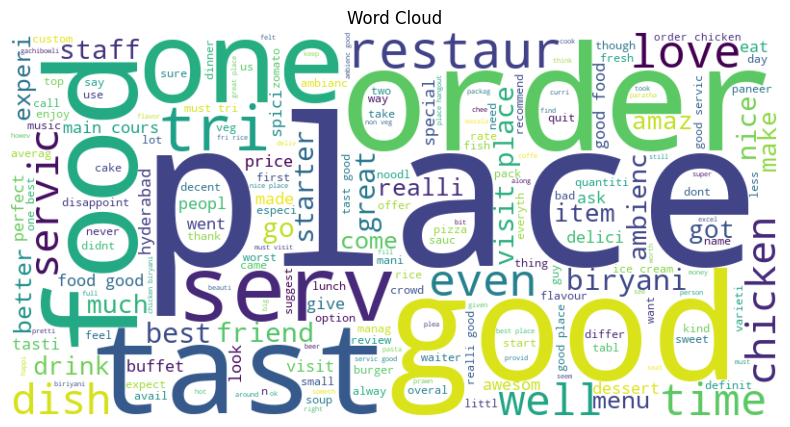

In [22]:
df['Review'] = df['Review'].apply(preprocess_data)
df.head()

all_words = ' '.join(df['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud")
plt.show()


## Modeling

In [23]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = df['Review']
y = df['target']


x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

7500 7500
2500 2500


In [24]:
train_reviews = df['Review'].values
train_target = df['target'].values

In [25]:
# Initialisez le Tokenizer et ajustez-le sur les textes d'entraînement
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_reviews)

# Calculez la taille du vocabulaire
vocab_length = len(word_tokenizer.word_index) + 1
print("La longueur du vocabulaire est :", vocab_length)

La longueur du vocabulaire est : 21242


In [26]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [27]:
print("Nombre de reviews dans train_reviews:", len(train_reviews))

Nombre de reviews dans train_reviews: 10000


In [28]:
# Tokenization alternative pour tout le dataset
tokenized_reviews = [review.split() for review in train_reviews]

# Longueur de la phrase la plus longue
length_long_sentence = max(len(sentence) for sentence in tokenized_reviews)

# Placeholder pour simuler des embeddings avec toutes les phrases
# Utilise une tokenization avec Keras ou d'autres méthodes de vectorisation
sequences = [[1, 2, 3, 4] for _ in range(10000)]  # Remplace par tes vraies séquences

train_padded_sentences = pad_sequences(sequences, maxlen=length_long_sentence, padding='post')

# Vérification des dimensions
print("Nombre de phrases padées :", len(train_padded_sentences))
print("Nombre de labels dans train_target :", len(train_target))

Nombre de phrases padées : 10000
Nombre de labels dans train_target : 10000


In [29]:
embedding_dim = 100
embeddings_dictionary = dict()
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [38]:
glove_file = 'glove.6B.100d.txt'
embeddings_dictionary = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_dictionary[word] = vector

In [41]:
def glove_lstm():
    model = Sequential()
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights=[embedding_matrix], 
        input_length=length_long_sentence, 
        trainable=False
    ))
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax')) 
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [42]:
model = glove_lstm()

history = model.fit(
    X_train,
    y_train,
    epochs=6,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
)


Epoch 1/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 70s 284ms/step - accuracy: 0.7104 - loss: 1.0203 - val_accuracy: 0.7648 - val_loss: 0.5499
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 68s 291ms/step - accuracy: 0.7424 - loss: 0.5809 - val_accuracy: 0.7648 - val_loss: 0.5505
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 53s 224ms/step - accuracy: 0.7490 - loss: 0.5710 - val_accuracy: 0.7648 - val_loss: 0.5654
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 52s 219ms/step - accuracy: 0.7443 - loss: 0.5743 - val_accuracy: 0.7648 - val_loss: 0.5481
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 52s 220ms/step - accuracy: 0.7507 - loss: 0.5687 - val_accuracy: 0.7648 - val_loss: 0.5564
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 51s 219ms/step - accuracy: 0.7520 - loss: 0.5628 - val_accuracy: 0.7648 - val_loss: 0.5632


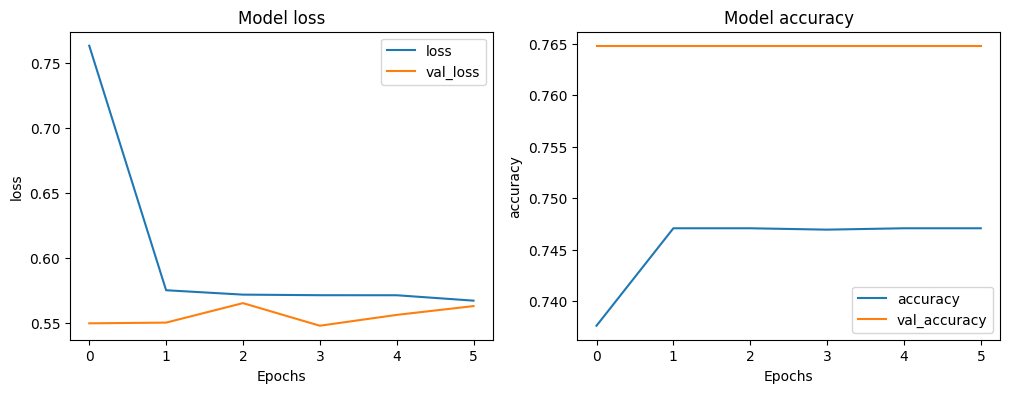

In [43]:
def plot_learning_curves(history, metrics):
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        for m in metric:
            plt.plot(history.history[m], label=m)
        plt.title('Model {}'.format(metric[0]))
        plt.xlabel('Epochs')
        plt.ylabel(metric[0])
        plt.legend()

    plt.show()

plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])


79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step
Accuracy: 0.7448

Classification Report:
               precision    recall  f1-score   support

           1       0.74      1.00      0.85      1862
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

   micro avg       0.74      1.00      0.85      1862
   macro avg       0.15      0.20      0.17      1862
weighted avg       0.74      1.00      0.85      1862



/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/victorasencio/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

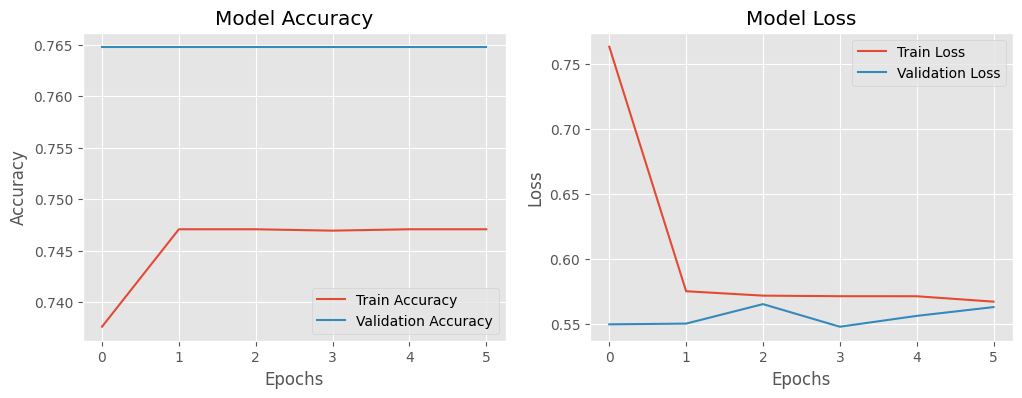

In [48]:
# Prédiction pour une classification multi-classes
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Évaluation pour 5 classes
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, labels=[1, 2, 3, 4, 5], target_names=["1", "2", "3", "4", "5"])

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

# Courbes d'apprentissage
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


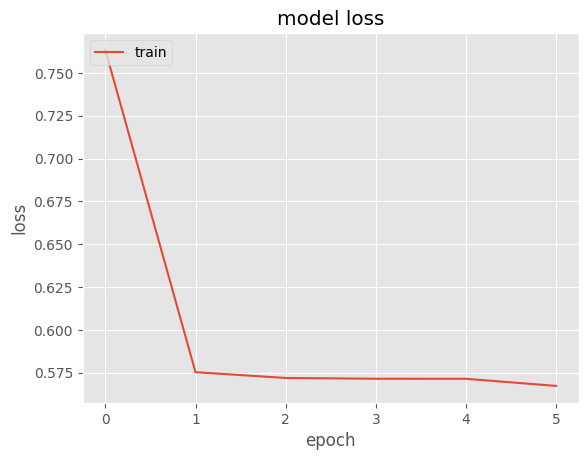

In [44]:
plt.style.use('ggplot')
%matplotlib inline

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
